# Generating h3 Hexgrids from GeoDataFrames

In [8]:
import geopandas  as gpd
import matplotlib.pyplot as plt
import pandas
import libpysal
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
%load_ext watermark
%watermark -v -a "author: eli knaap" -d -u -p tobler,cenpy,geopandas

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: author: eli knaap

Last updated: 2022-03-21

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 7.32.0

tobler   : 0.9.0
cenpy    : 1.0.0.post4
geopandas: 0.10.2



**Note**: This notebook relies on functionality from the [`contextily`](https://contextily.readthedocs.io/en/latest/) package that provides convenient basemaps for geospatial plots, and the [`cenpy`](https://cenpy-devs.github.io/cenpy/) package that provide a convenient interface to the U.S. Census API. These can be installed with  
  
`pip install contextily cenpy`     
or    
`conda install contextily cenpy -c conda-forge`

In [9]:
import contextily as ctx
from cenpy import products

## Getting data from CenPy

To begin with, we will fetch some data from the 2017 ACS

In [10]:
acs = products.ACS(2017)

We're looking for median home value, so first we will filter the ACS tables by those containing "value" in the description so we can find the correct variable code

In [11]:
acs.filter_tables('VALUE', by='description')

,description,columns
table_name,,
B25075,VALUE,"[B25075_001E, B25075_002E, B25075_003E, B25075..."
B25076,LOWER VALUE QUARTILE (DOLLARS),[B25076_001E]
B25077,MEDIAN VALUE (DOLLARS),[B25077_001E]
B25078,UPPER VALUE QUARTILE (DOLLARS),[B25078_001E]
B25079,AGGREGATE VALUE (DOLLARS) BY AGE OF HOUSEHOLDER,"[B25079_001E, B25079_002E, B25079_003E, B25079..."
B25080,AGGREGATE VALUE (DOLLARS) BY UNITS IN STRUCTURE,"[B25080_001E, B25080_002E, B25080_003E, B25080..."
B25082,AGGREGATE VALUE (DOLLARS) BY MORTGAGE STATUS,"[B25082_001E, B25082_002E, B25082_003E]"
B25083,MEDIAN VALUE (DOLLARS) FOR MOBILE HOMES,[B25083_001E]
B25096,MORTGAGE STATUS BY VALUE,"[B25096_001E, B25096_002E, B25096_003E, B25096..."


The variable we're looking for is `B25077_001E`, the median home value of each. Lets collect that data for the Washington DC metropolitan region. The next cell can take a minute or two to run, depending on the speed of your connection.

In [12]:
dc = acs.from_msa('Washington-Arlington', variables=['B25077_001E'])

C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the chang

In [13]:
dc.head()

,GEOID,geometry,B25077_001E,NAME,state,county,tract
0,51187020400,"POLYGON ((-8707449.640 4712119.860, -8707429.2...",168600.0,"Census Tract 204, Warren County, Virginia",51,187,020400
1,51157950200,"POLYGON ((-8720541.590 4668443.050, -8720529.7...",387300.0,"Census Tract 9502, Rappahannock County, Virginia",51,157,950200
2,51061930203,"POLYGON ((-8697522.390 4702805.320, -8697486.9...",450400.0,"Census Tract 9302.03, Fauquier County, Virginia",51,061,930203
3,54037972501,"POLYGON ((-8674439.180 4759547.960, -8674423.8...",241500.0,"Census Tract 9725.01, Jefferson County, West V...",54,037,972501
4,54037972300,"POLYGON ((-8682474.560 4768482.630, -8682465.3...",217800.0,"Census Tract 9723, Jefferson County, West Virg...",54,037,972300


## Creating Hexgrids with the `h3fy` function

Using the `h3fy` function from the `tobler.util` module, we can easily generate a hexgrid covering the face of the DC Metropolitan region

In [14]:
dc_hex = h3fy(dc)

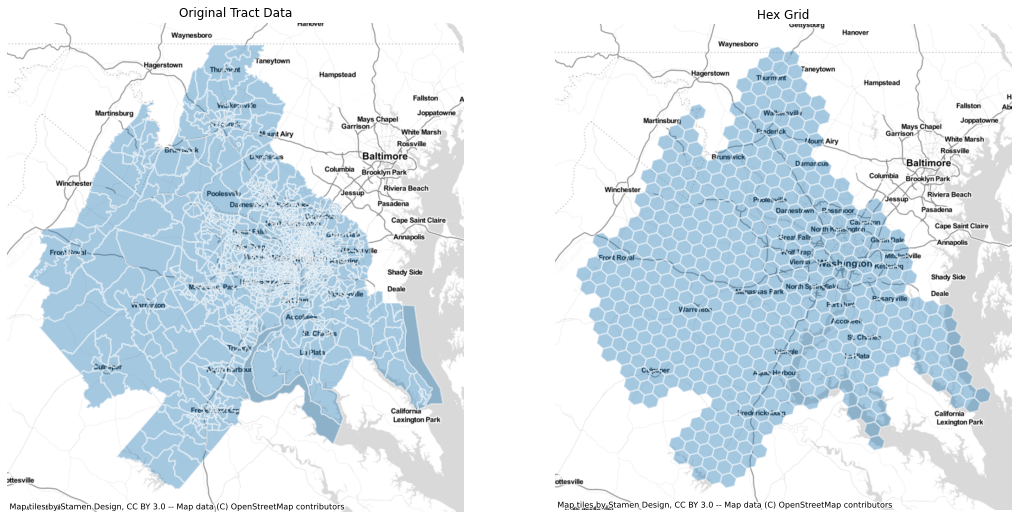

In [15]:
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

dc.plot(ax=axs[0], alpha=0.4, linewidth=1.6, edgecolor='white')
dc_hex.plot(ax=axs[1], alpha=0.4, linewidth=1.6, edgecolor='white')

axs[0].set_title('Original Tract Data')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    ctx.add_basemap(axs[i], source=ctx.providers.Stamen.TonerLite)
    axs[i].axis('off')

By altering the `resolution` parameter, we can generate grids using hexes of various sizes

In [16]:
dc_hex_large = h3fy(dc, resolution=5)
dc_hex_small = h3fy(dc, resolution=7)

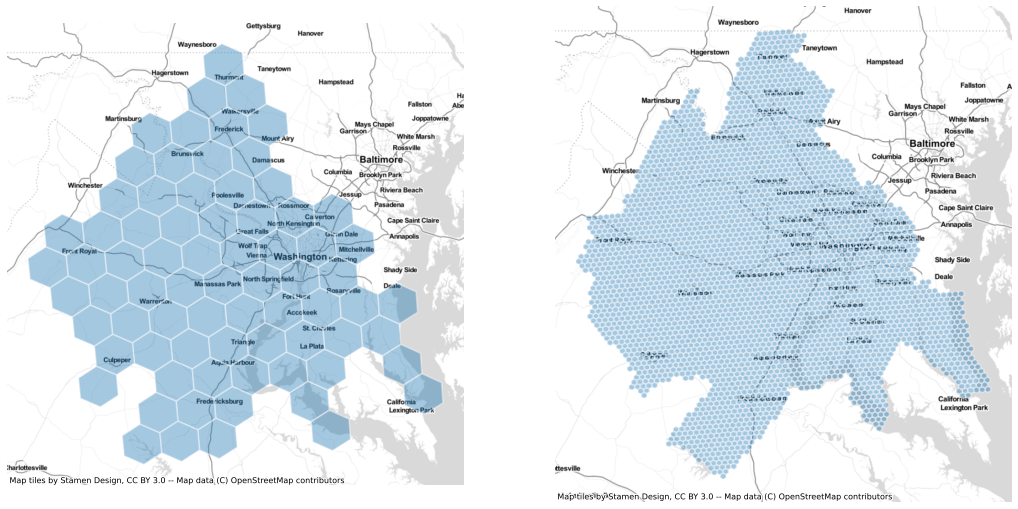

In [17]:
fig, axs = plt.subplots(1,2, figsize=(18,10))

dc_hex_large.plot(ax=axs[0], alpha=0.4, linewidth=1.6, edgecolor='white')
dc_hex_small.plot(ax=axs[1], alpha=0.4, linewidth=1.6, edgecolor='white')

for ax in axs:
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
    ax.axis('off')

and by using the `clip` parameter, we can ensure that the hexgrid is does not extend beyond the borders of the input geodataframe

In [18]:
dc_hex_clipped = h3fy(dc, resolution=5, clip=True)

(-8738395.659999996, -8484578.8, 4575391.257202433, 4837245.453466552)

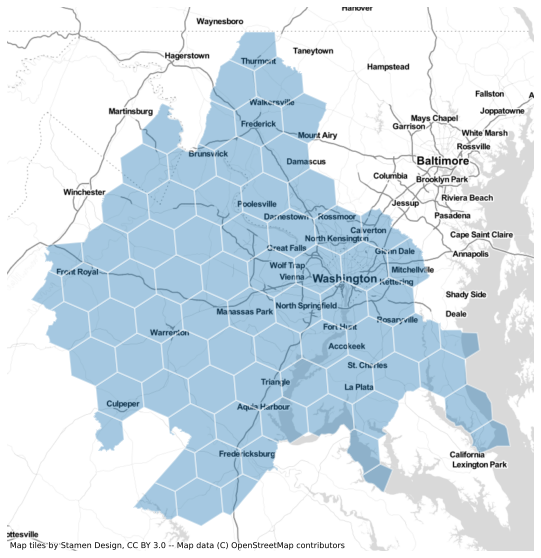

In [19]:
fig, ax = plt.subplots(figsize=(10,10))

dc_hex_clipped.plot(ax=ax, alpha=0.4, linewidth=1.6, edgecolor='white')
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
ax.axis('off')

## Interpolating to a hexgrid

Thus, in just a few lines of code, we can estimate the value of census variables represented by a regular hexgrid

here, we will estimate the median home value of each hex in the DC region using simple areal interpolation

In [20]:
dc_hex_interpolated = area_interpolate(source_df=dc, target_df=dc_hex, intensive_variables=['B25077_001E'])

C:\Users\Youss\AppData\Local\Programs\Python\Python39\lib\site-packages\tobler\util\util.py:32: UserWarning: nan values in variable: B25077_001E, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")


Text(0.5, 0.98, 'Spatial Interpolation with the PySAL $\\mathtt{tobler}$ package')

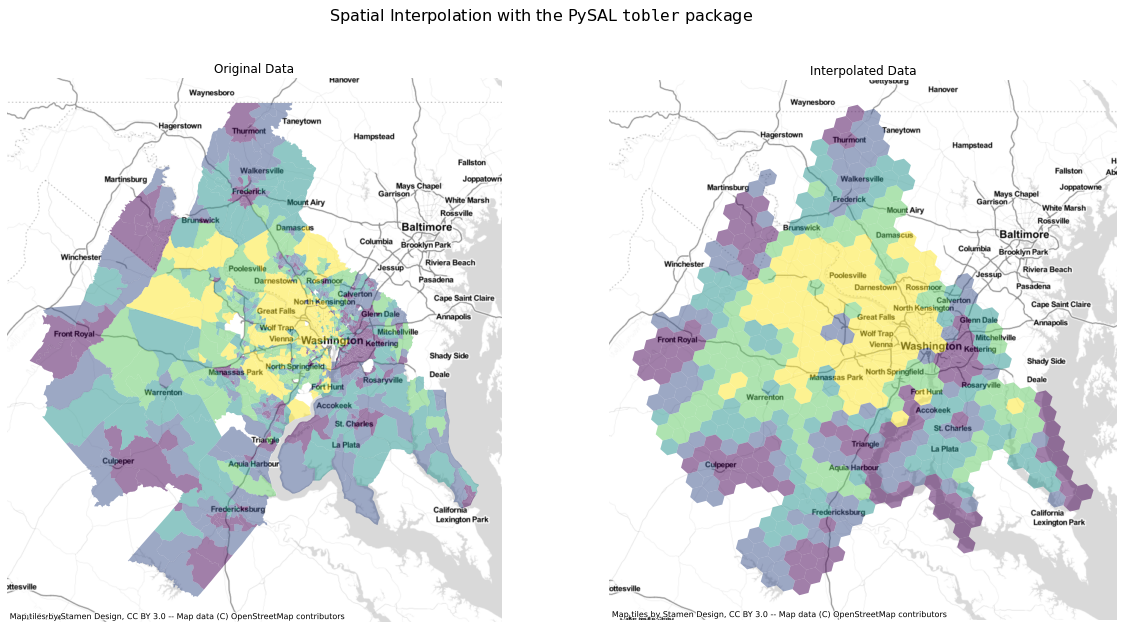

In [21]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
dc.plot('B25077_001E', scheme='quantiles', alpha=0.5, ax=axs[0])

dc_hex_interpolated.plot('B25077_001E', scheme='quantiles', alpha=0.5, ax=axs[1])

axs[0].set_title('Original Data')
axs[1].set_title('Interpolated Data')
           
for ax in axs:
    ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)
    ax.axis('off')
plt.suptitle('Spatial Interpolation with the PySAL $\mathtt{tobler}$ package', fontsize=16)